In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:

# Function for preprocessing data
def preprocess_data(file_path, sample_frac=0.4, random_state=42):
    # Load the dataset
    df = pd.read_csv(file_path)
    df = df.sample(frac=sample_frac, random_state=random_state)
    
    # Drop unnecessary columns
    df = df.drop(['internalTaxonId', 'scientificName'], axis=1)
    
    # Encode categorical features
    label_encoders = {}
    for col in ['speciesName', 'systems', 'scopes', 'Category']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Separate features and target
    X = df.drop('Category', axis=1)
    y = df['Category']

    # Split data: 80% train, 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save the scaler and label encoders for future use
    joblib.dump(scaler, "scaler.pkl")
    joblib.dump(label_encoders, "label_encoders.pkl")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, df, label_encoders


In [3]:

# Function to create a model
def create_model(input_shape):
    # Define the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # Output layer for multi-class classification
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
def visualize_data(df, label_encoders, output_dir="visualizations"):
    # Create the directory for saving visuals
    os.makedirs(output_dir, exist_ok=True)

    # Decode the 'Category' column for visualization using inverse_transform
    df['Category_decoded'] = label_encoders['Category'].inverse_transform(df['Category'])

    # Target variable distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Category_decoded', data=df, order=df['Category_decoded'].value_counts().index)
    plt.title("Distribution of Target Variable (Category)")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(output_dir, "category_distribution.png"))
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.savefig(os.path.join(output_dir, "correlation_heatmap.png"))
    plt.show()

    # Top 10 most common species names
    df['speciesName_decoded'] = label_encoders['speciesName'].inverse_transform(df['speciesName'])
    plt.figure(figsize=(10, 6))
    df['speciesName_decoded'].value_counts().head(10).plot(kind='bar', color='skyblue')
    plt.title("Top 10 Most Common Species Names")
    plt.xlabel("Species Name")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(output_dir, "top_species_names.png"))
    plt.show()


In [5]:

# Function to evaluate the model
def evaluate_model(model, X_test_scaled, y_test):
    # Predict probabilities and classes
    predictions_proba = model.predict(X_test_scaled)
    predictions = np.argmax(predictions_proba, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    # Evaluate loss
    loss, _ = model.evaluate(X_test_scaled, y_test, verbose=0)

    # Print the scores
    print(f"Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Visualize the metrics
    metrics = {'Accuracy': accuracy, 'Loss': loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), metrics.values(), color='skyblue')
    plt.title("Model Evaluation Metrics")
    plt.ylabel("Score")
    plt.show()

    return metrics



In [7]:
# Main workflow
file_path = 'species_data.csv'
X_train_scaled, X_test_scaled, y_train, y_test, df, label_encoders = preprocess_data(file_path)


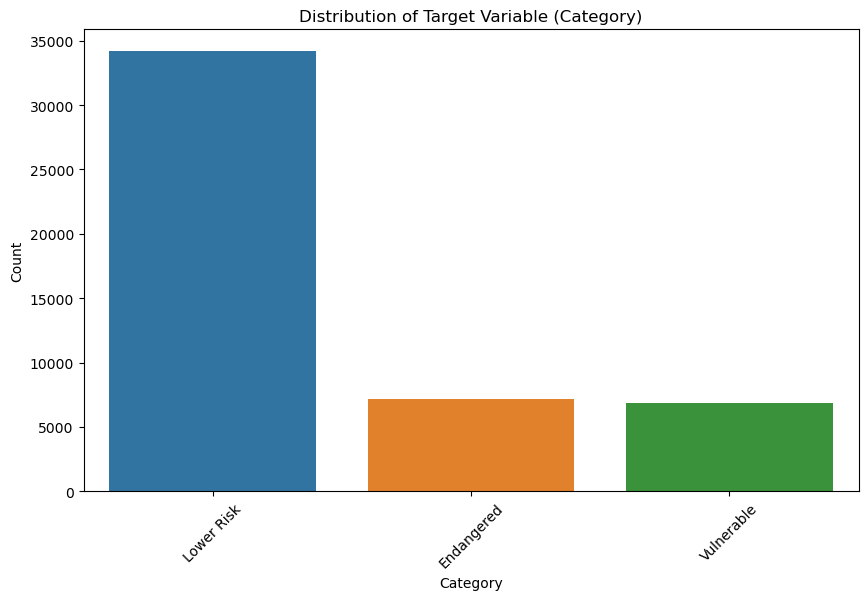

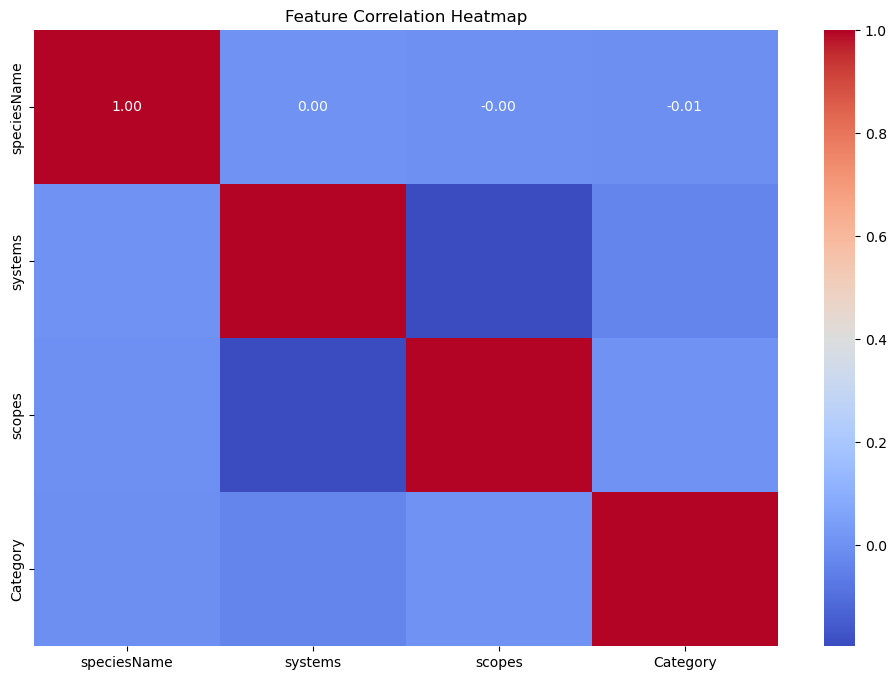

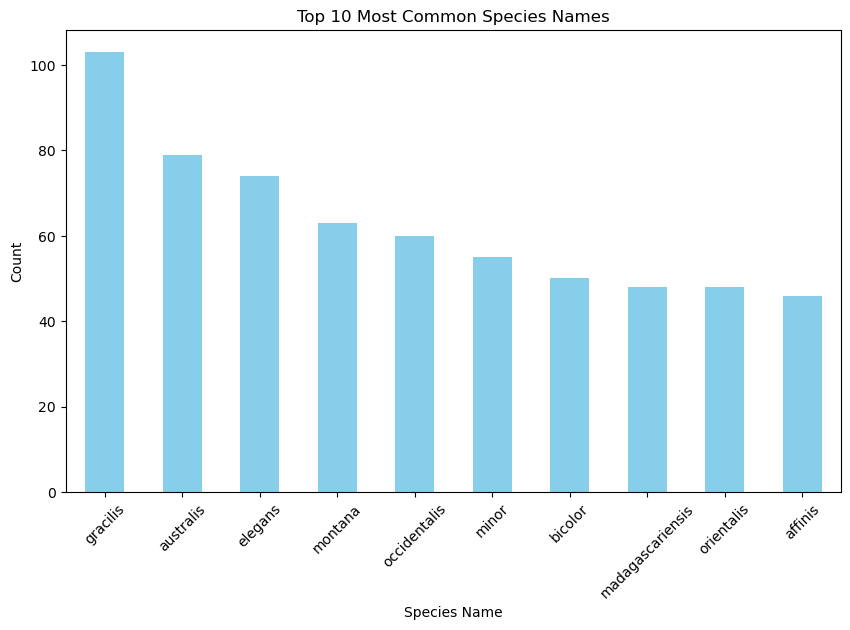

In [14]:

# Visualize the data
visualize_data(df, label_encoders)

In [9]:


# Create and train the model
model = create_model(X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32)


Epoch 1/20
1206/1206 [==============================] - 2s 1ms/step - loss: 0.7996 - accuracy: 0.7094
Epoch 2/20
1206/1206 [==============================] - 2s 1ms/step - loss: 0.7891 - accuracy: 0.7096
Epoch 3/20
1206/1206 [==============================] - 2s 1ms/step - loss: 0.7876 - accuracy: 0.7096
Epoch 4/20
1206/1206 [==============================] - 2s 1ms/step - loss: 0.7871 - accuracy: 0.7096
Epoch 5/20
1206/1206 [==============================] - 2s 1ms/step - loss: 0.7859 - accuracy: 0.7096
Epoch 6/20
1206/1206 [==============================] - 1s 1ms/step - loss: 0.7856 - accuracy: 0.7096
Epoch 7/20
1206/1206 [==============================] - 2s 1ms/step - loss: 0.7852 - accuracy: 0.7096
Epoch 8/20
1206/1206 [==============================] - 1s 1ms/step - loss: 0.7854 - accuracy: 0.7096
Epoch 9/20
1206/1206 [==============================] - 2s 1ms/step - loss: 0.7850 - accuracy: 0.7096
Epoch 10/20
1206/1206 [==============================] - 2s 1ms/step - loss: 0.784

302/302 [==============================] - 0s 1ms/step


c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Metrics:
Accuracy: 0.7035
Loss: 0.7927
Precision: 0.4949
Recall: 0.7035
F1 Score: 0.5810


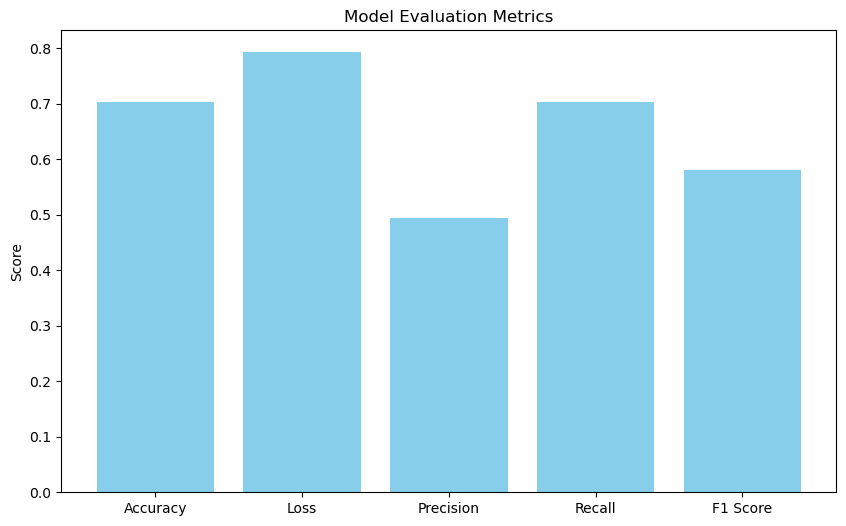

In [10]:
metrics = evaluate_model(model, X_test_scaled, y_test)

In [15]:
# Save the model
os.makedirs("saved_models", exist_ok=True)
model.save("saved_models/model_simple.h5")

# Evaluate the model